In [1]:
from libpysal import weights, examples
from contextily import add_basemap
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import geopandas
import pandas as pd



<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def stats(G, path, path_w):
    subG = G.subgraph(path)
    print('Normal route: ')
    print('total weight: ', subG.size(weight="weight"))
    print('total noise: ', subG.size(weight="noise"))
    print('total dist: ', subG.size(weight="dist"))
    print('total pollution: ', subG.size(weight="rang"))
    print('')
    subG_w = G.subgraph(path_w)
    print('Green route: ')
    print('total weight: ', subG_w.size(weight="weight"))
    print('total noise: ', subG_w.size(weight="noise"))
    print('total dist: ', subG_w.size(weight="dist"))
    print('total pollution: ', subG_w.size(weight="rang"))
    print('_______________')
    print('Improvement: ')
    print('total weight: ', subG_w.size(weight="weight")/subG.size(weight="weight")*100, '%')
    print('total noise: ', subG_w.size(weight="noise")/subG.size(weight="noise")*100, '%')
    print('total dist: ', subG_w.size(weight="dist")/subG.size(weight="dist")*100, '%')
    print('total pollution: ', subG_w.size(weight="rang")/subG.size(weight="rang")*100, '%')

In [3]:
def stats_alpha(alpha, from_node, to_node, verbose = 1):

    def weight(row, alpha):
        beta = 1 - alpha
        return alpha * row.TOTAL_D + alpha * row.Rang + beta * row.LONGITUD
    edges['weights'] = edges.apply (lambda row: weight(row, alpha), axis=1)
    G = nx.Graph()
    for i, edge in edges.iterrows():
        G.add_edge(edge['FID_x'], edge['FID_y'], noise =  edge['TOTAL_D'], rang = edge['Rang'],  dist = edge['LONGITUD'], weight=edge['weights'])

    path_w = nx.shortest_path(G,from_node,to_node, 'weight')
    path = nx.shortest_path(G,from_node,to_node, 'dist')
        
    subG = G.subgraph(path)
    subG_w = G.subgraph(path_w)
    imp_w = subG_w.size(weight="weight")/subG.size(weight="weight")*100
    imp_d = subG_w.size(weight="dist")/subG.size(weight="dist")*100
    imp_p =  subG_w.size(weight="rang")/subG.size(weight="rang")*100
    imp_n = subG_w.size(weight="noise")/subG.size(weight="noise")*100
    
    if verbose == 1:
        print('Normal route: ')
        print('total weight: ', subG.size(weight="weight"))
        print('total noise: ', subG.size(weight="noise"))
        print('total dist: ', subG.size(weight="dist"))
        print('total pollution: ', subG.size(weight="rang"))
        print('')
        print('Green route: ')
        print('total weight: ', subG_w.size(weight="weight"))
        print('total noise: ', subG_w.size(weight="noise"))
        print('total dist: ', subG_w.size(weight="dist"))
        print('total pollution: ', subG_w.size(weight="rang"))
        print('_______________')
        print('Improvement: ')
        print('total weight: ', subG_w.size(weight="weight")/subG.size(weight="weight")*100, '%')
        print('total noise: ', subG_w.size(weight="noise")/subG.size(weight="noise")*100, '%')
        print('total dist: ', subG_w.size(weight="dist")/subG.size(weight="dist")*100, '%')
        print('total pollution: ', subG_w.size(weight="rang")/subG.size(weight="rang")*100, '%')
    return imp_w, imp_d, imp_p, imp_n
        

In [7]:
import pickle
with open('../data/positions.pkl', 'rb') as f:
    positions = pickle.load(f)

In [6]:
edges = pd.read_csv('../data/graph_mix.csv')

In [8]:
def weight(row, alpha):
    beta = 1 - alpha
    return alpha * row.TOTAL_D + alpha * row.Rang + beta * row.LONGITUD

alpha = 0.7
edges['weights'] = edges.apply (lambda row: weight(row, alpha), axis=1)

In [9]:
node_features = []
for node in range(max(edges.FID_y)+1):
    result = edges[(edges['FID_x'] == node) | (edges['FID_y'] == node)].Rang
    if len(result)>0:
        node_features.append([node, sum(result)/len(result) ])
        
node_features_pd = pd.DataFrame(node_features, columns=['nodes', 'features'])


In [10]:
len(node_features_pd)

9389

In [8]:
G = nx.Graph()

for i, node in node_features_pd.iterrows():
    G.add_node(node['nodes'], feature=node['features'])
    
for i, edge in edges.iterrows():
    G.add_edge(edge['FID_x'], edge['FID_y'], noise =  edge['TOTAL_D'], rang = edge['Rang'],  dist = edge['LONGITUD'], weight=edge['weights'])

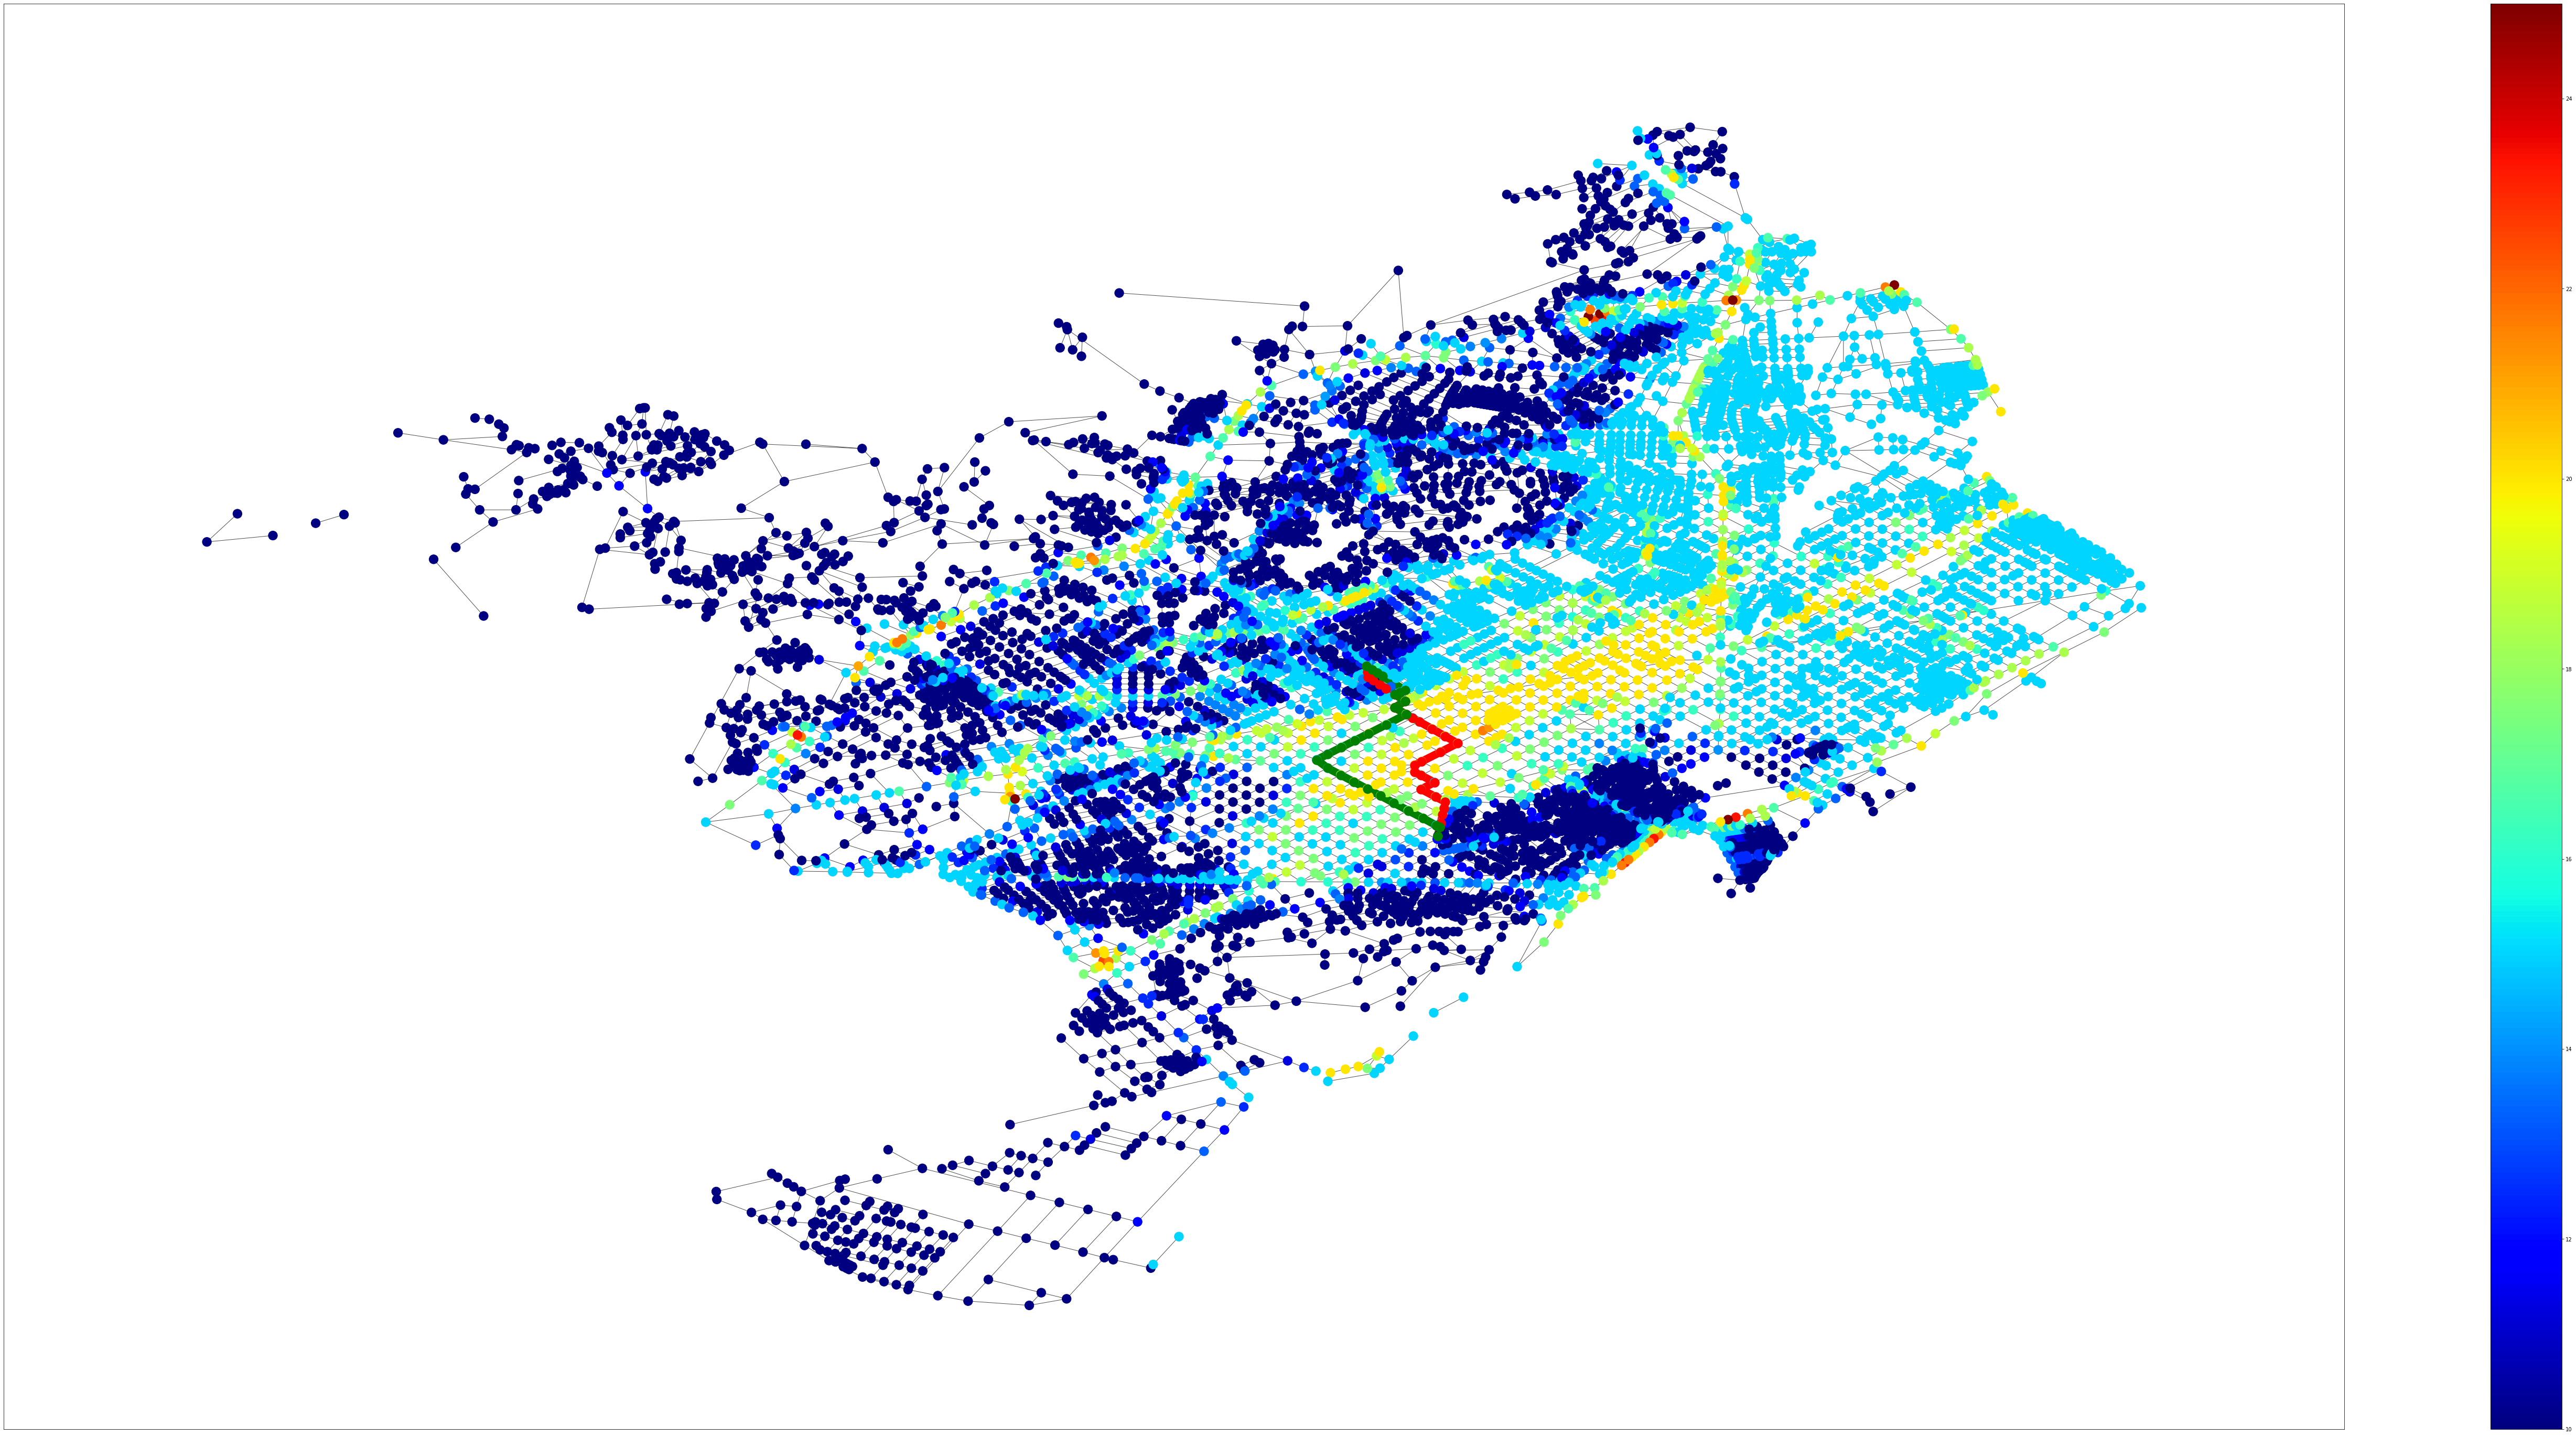

In [19]:
from_node = 800
to_node = 4300


path_w = nx.shortest_path(G,from_node,to_node, 'weight')
path = nx.shortest_path(G,from_node,to_node, 'dist')

path_edges = list(zip(path,path[1:]))
path_edges_w = list(zip(path_w,path_w[1:]))


plt.figure(figsize=[100,50])
ec = nx.draw_networkx_edges(G, pos=positions, alpha=0.7)
nc = nx.draw_networkx_nodes(G, pos=positions, node_color=node_features_pd.features, cmap=plt.cm.jet)
plt.colorbar(nc)
nx.draw_networkx_nodes(G,positions,nodelist=path,node_color='r')
nx.draw_networkx_edges(G,positions,edgelist=path_edges,edge_color='r',width=15)

nx.draw_networkx_nodes(G,positions,nodelist=path_w,node_color='g')
nx.draw_networkx_edges(G,positions,edgelist=path_edges_w,edge_color='g',width=15)

plt.show()

In [20]:
stats(G, path, path_w)

Normal route: 
total weight:  2627.5889000000006
total noise:  1985.0
total dist:  2971.963
total pollution:  495.0

Green route: 
total weight:  2398.5224
total noise:  1650.0
total dist:  3153.4080000000004
total pollution:  425.0
_______________
Improvement: 
total weight:  91.2822549981087 %
total noise:  83.12342569269522 %
total dist:  106.10522405561578 %
total pollution:  85.85858585858585 %


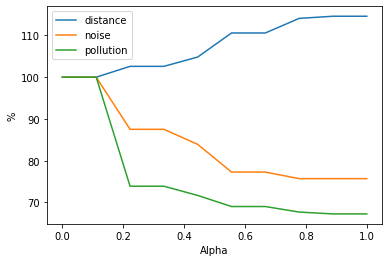

In [22]:
alphas = np.linspace(0, 1, 10)
imp_d_list = []
imp_n_list = []
imp_p_list = []
for alpha in alphas:
    imp_w, imp_d, imp_p, imp_n = stats_alpha(alpha, 300, 4000, verbose = 0)
    imp_d_list.append(imp_d)
    imp_n_list.append(imp_n)
    imp_p_list.append(imp_p)
    
plt.plot(alphas, imp_d_list, label = 'distance')
plt.plot(alphas, imp_n_list, label = 'noise')
plt.plot(alphas, imp_p_list, label = 'pollution')
plt.xlabel('Alpha')
plt.ylabel('%')
plt.legend()
plt.show()